In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pdb
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import time
import glob
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
import itertools
from sklearn.model_selection import KFold

In [4]:
sys.path.append('/home/akumar/nse/neural_control')
from utils import apply_df_filters, calc_loadings
from loaders import load_sabes
from segmentation import reach_segment_sabes
from decoders import lr_decode_windowed

In [5]:
start_times = {'indy_20160426_01': 0,
               'indy_20160622_01':1700,
               'indy_20160624_03': 500,
               'indy_20160627_01': 0,
               'indy_20160630_01': 0,
               'indy_20160915_01': 0,
               'indy_20160921_01': 0,
               'indy_20160930_02': 0,
               'indy_20160930_05': 300,
               'indy_20161005_06': 0,
               'indy_20161006_02': 350,
               'indy_20161007_02': 950,
               'indy_20161011_03': 0,
               'indy_20161013_03': 0,
               'indy_20161014_04': 0,
               'indy_20161017_02': 0,
               'indy_20161024_03': 0,
               'indy_20161025_04': 0,
               'indy_20161026_03': 0,
               'indy_20161027_03': 500,
               'indy_20161206_02': 5500,
               'indy_20161207_02': 0,
               'indy_20161212_02': 0,
               'indy_20161220_02': 0,
               'indy_20170123_02': 0,
               'indy_20170124_01': 0,
               'indy_20170127_03': 0,
               'indy_20170131_02': 0,
               }

### Sabes

Basic question: If we isolate neural activity at some lag prior to when the reach velocity is below some threshold vs the period of time when it crosses this period of time, if there any signficiant difference in 
subspace occupancies?

In [4]:
# First, identify windows around the target transition times during which the velocity is below some threshold

In [6]:
with open('/home/akumar/nse/neural_control/data/sabes_decoding_df.dat', 'rb') as f:
    sabes_df1 = pickle.load(f)
data_files = np.unique(sabes_df1['data_file'].values)
del sabes_df1

In [7]:
data_file = data_files[0]
dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file)
dat = reach_segment_sabes(dat, start_times[data_file.split('.mat')[0]])

Processing spikes


100%|██████████| 1/1 [00:14<00:00, 14.69s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


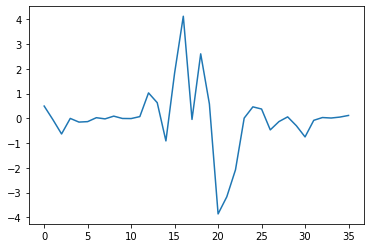

In [34]:
plt.plot(np.diff(vel))

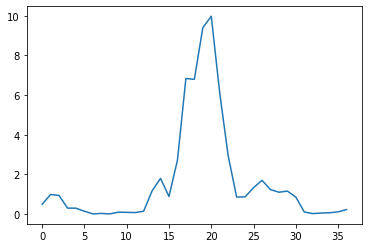

In [32]:
plt.plot(vel)zz

In [11]:
dat['transition_times'][0]

(10, 50)

In [11]:
n_transitions = len(dat['transition_times'])

zero_vel_windows = []
#lags = np.arange(4)
shift = 15
for i in range(1, n_transitions):
    vel = np.linalg.norm(np.diff(dat['behavior'][dat['transition_times'][i][0] - shift:dat['transition_times'][i][1], :], axis=0), axis=1)
    a = np.squeeze(np.argwhere(np.abs(np.diff(vel)) <= 0.1))

    # Identify consecutive windows
    windows = consecutive(a)

    # Identify the window that contains the shift
    membership = np.where([shift in w for w in windows])[0]

    # If no window contains the shift, then we cannot use this transition
    if membership.size == 0:
        continue
    else:
        # Convert to indices that can be used to directly splice the data.
        window = dat['transition_times'][i][0] - shift + windows[membership[0]] + 1

        # Ensure that the timesteps following the stationary period are associated with 
        # a robust increase in hand velocity
        if np.linalg.norm(dat['behavior'][window[-1] + 4, :] - dat['behavior'][window[-1] + 3, :]) < 3:
            continue
        else:
            zero_vel_windows.append((i, window))    

In [12]:
l = [len(z[1]) for z in zero_vel_windows]

(array([23., 29., 48., 50., 27., 57., 14.,  8.,  3.,  2.]),
 array([ 1. ,  2.8,  4.6,  6.4,  8.2, 10. , 11.8, 13.6, 15.4, 17.2, 19. ]),
 <BarContainer object of 10 artists>)

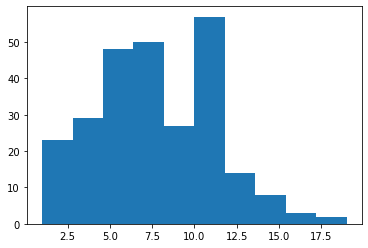

In [13]:
plt.hist(l)

In [14]:
# Plot the velocity in our identified windows and in the 

In [15]:
valid_windows = np.array(zero_vel_windows)[np.argwhere(np.array(l) > 6)[:, 0]]

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [19]:
dat['transition_times'][window[0]]

(9287, 9330)

In [17]:
window[1]

array([9281, 9282, 9283, 9284, 9285, 9286, 9287, 9288, 9289, 9290, 9291])

In [21]:
idxs[-1] - trans

9297

In [36]:
3/.05

60.0

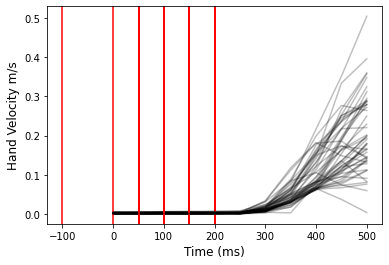

In [34]:
# Also plot when the target switches
fig, ax = plt.subplots()
for window in valid_windows[0:50]:
    idxs = window[1][-6:]
    idxs = np.concatenate([idxs, idxs + 6])
    tt = dat['transition_times'][window[0]][0] - idxs[0]
    vel = np.linalg.norm(np.diff(dat['behavior'][idxs], axis=0), axis=1)/(1e3 * 0.05)
    ax.plot(50 * np.arange(idxs.size - 1) , vel, color='k', alpha=0.25)
    ax.axvline(x=tt * 50, color='r')

ax.set_ylabel('Hand Velocity m/s', fontsize=12)
ax.set_xlabel('Time (ms)', fontsize=12)
fig.savefig('/home/akumar/nse/neural_control/figs/decodingvtsummary/prep.pdf', bbox_inches='tight', pad_inches=0)

In [10]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def get_windows(dat, shift=15, min_width=6, acc_thresh=0.1, vel_thresh=3):

    n_transitions = len(dat['transition_times'])

    zero_vel_windows = []
    #lags = np.arange(4)

    for i in range(1, n_transitions):
        vel = np.linalg.norm(np.diff(dat['behavior'][dat['transition_times'][i][0] - shift:dat['transition_times'][i][1], :], axis=0), axis=1)
        a = np.squeeze(np.argwhere(np.abs(np.diff(vel)) <= acc_thresh))

        # Identify consecutive windows
        try:
            windows = consecutive(a)
        except:
            continue

        # Identify the window that contains the shift
        membership = np.where([shift in w for w in windows])[0]

        # If no window contains the shift, then we cannot use this transition
        if membership.size == 0:
            continue
        else:
            # Convert to indices that can be used to directly splice the data.
            window = dat['transition_times'][i][0] - shift + windows[membership[0]] + 1

            # Ensure that the timesteps following the stationary period are associated with 
            # a robust increase in hand velocity
            if np.linalg.norm(dat['behavior'][window[-1] + 4, :] - dat['behavior'][window[-1] + 3, :]) < vel_thresh:
                continue
            else:
                zero_vel_windows.append((i, window))

    l = [len(z[1]) for z in zero_vel_windows]
    valid_windows = np.array(zero_vel_windows)[np.argwhere(np.array(l) > min_width)[:, 0]]
    return valid_windows

In [126]:
from orth_pca import OrthPCA

In [129]:
widths = [6, 10]
dims = [2, 6, 10, 15, 20]
lags = np.arange(4)
reps = 5
rl = []

for i, data_file in tqdm(enumerate(data_files)):
    dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file)    
    dat = reach_segment_sabes(dat, start_times[data_file.split('.mat')[0]])

    for width in widths:
        for lag in lags:

            valid_windows = get_windows(dat, min_width=width)

            # Assemble data matrices
            X = np.squeeze(dat['spike_rates'])
            x1 = []
            x2 = []
            for window in valid_windows:
                x1.append(X[window[1][-width:]])
                x2.append(X[window[1][-width:] + width])     

            # squash trials
            x1 = np.concatenate(x1)
            x2 = np.concatenate(x2)

            for d in dims:    
                for rep in range(reps:
                    opca = OrthPCA(d1=d, d2=d)
                    V1, V2, _, vf1, vf2 = opca.fit(x1, x2)    

                    result = {}
                    result['data_file'] = data_file
                    result['width'] = width
                    result['lag'] = lag
                    result['dim'] = d
                    result['rep'] = rep

                    result['V1'] = V1
                    result['V2'] = V2
                    result['vf1'] = vf1
                    result['vf2'] = vf2

                    rl.append(result)

0it [00:00, ?it/s]

Processing spikes


100%|██████████| 1/1 [00:14<00:00, 14.85s/it]
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
1it [02:46, 166.43s/it]

Processing spikes


100%|██████████| 1/1 [00:20<00:00, 20.35s/it]
2it [05:21, 159.53s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.24s/it]
3it [05:55, 102.27s/it]

Processing spikes


100%|██████████| 1/1 [00:27<00:00, 27.88s/it]
4it [08:29, 122.77s/it]

Processing spikes


100%|██████████| 1/1 [00:12<00:00, 12.22s/it]
5it [09:56, 109.86s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.19s/it]
6it [11:03, 95.19s/it] 

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.02s/it]
7it [12:38, 95.25s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.85s/it]
8it [14:32, 101.12s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.47s/it]
9it [16:27, 105.50s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.10s/it]
10it [17:50, 98.64s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.17s/it]
11it [19:50, 105.12s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.11s/it]
12it [21:52, 110.33s/it]

Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.63s/it]
13it [23:42, 110.04s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.33s/it]
14it [24:58, 100.02s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.33s/it]
15it [26:53, 104.41s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.11s/it]
16it [28:19, 98.74s/it] 

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.90s/it]
17it [29:36, 92.28s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.28s/it]
18it [31:38, 101.37s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.17s/it]
19it [33:24, 102.60s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.81s/it]
20it [35:14, 105.01s/it]

Processing spikes


100%|██████████| 1/1 [00:06<00:00,  6.17s/it]
21it [36:57, 104.37s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.74s/it]
22it [38:38, 103.15s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.84s/it]
23it [39:42, 91.36s/it] 

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.89s/it]
24it [41:18, 92.84s/it]

Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.08s/it]
25it [43:02, 96.35s/it]

Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.03s/it]
26it [45:02, 103.36s/it]

Processing spikes


100%|██████████| 1/1 [00:06<00:00,  6.16s/it]
27it [46:10, 92.77s/it] 

Processing spikes


100%|██████████| 1/1 [00:06<00:00,  6.87s/it]
28it [47:58, 102.82s/it]


In [ ]:
# Need to try multiple initializations